In [1]:
!pip install langchain langgraph langsmith langchain-groq langchain_community langchain-tavily

INFO: pip is looking at multiple versions of langchain-groq to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is still looking at multiple versions of langchain-community to determine which version is compatible with other requirements

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.message import add_messages

In [3]:
groq_api_key="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"
tavily_api_key="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"

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.3-70b-versatile", groq_api_key=groq_api_key)

In [5]:
class State(TypedDict):
  """
  Messages have the type 'list'. The 'add_messages' function in the annotation defines how this state key should be updated.
  (in this case, it appends messages to the list, rather than overwriting them.)
  """
  messages: Annotated[list, add_messages]

In [6]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2, tavily_api_key=tavily_api_key)

#Custom function
def multiply(a: int, b: int) -> int:
  """
  Multiply a and b
  Args:
      a-> int
      b-> int
  Returns:
      int
  """
  return a * b

In [7]:
tools = [tool, multiply]
llm_with_tools = llm.bind_tools(tools)

In [8]:
## Node definition -> to transfer State knowledges(Chat history) to llm
def tool_calling_llm(state: State):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}


In [9]:
# Graph builder
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges (Connection buildup through node)
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # IF the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # IF the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)

builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

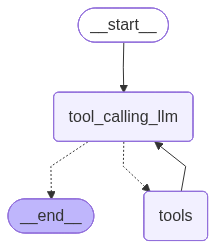

In [10]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (j80g9s6dc)
 Call ID: j80g9s6dc
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
  multiply (4y0hyp5hw)
 Call ID: 4y0hyp5hw
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.manufacturing.net/artificial-intelligence/news/22954247/survey-reveals-manufacturing-businesses-struggle-with-genai-skills-gap", "title": "Survey Reveals Manufacturing Businesses Struggle with GenAI Skills Gap - Manufacturing.net", "score": 0.7429634, "published_date": "Wed, 05 Nov 2025 00:00:00 GMT", "content": "Latest in Artificial Intelligence\n\nSpo

## Adding Memory in Agentic Graph

In [12]:
response = graph.invoke({"messages": "Hello my name is Akib"})
for m in response["messages"]:
  m.pretty_print()

================================ Human Message =================================

Hello my name is Akib
================================== Ai Message ==================================

Hello Akib, it's nice to meet you. Is there something I can help you with or would you like to chat?


In [13]:
response=graph.invoke({"messages":"what is my name"})
response

{'messages': [HumanMessage(content='what is my name', additional_kwargs={}, response_metadata={}, id='de35b3bc-829b-4be9-8254-1ad5f00a92a9'),
  AIMessage(content="I don't have any information about your name. This conversation just started, and we haven't discussed any personal details yet. If you'd like to share your name, I'd be happy to chat with you!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 1885, 'total_tokens': 1929, 'completion_time': 0.12124533, 'prompt_time': 0.095608961, 'queue_time': 0.062423137, 'total_time': 0.216854291}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fe312f6b04', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--775d3640-3796-49ee-b6bb-4ce64acda854-0', usage_metadata={'input_tokens': 1885, 'output_tokens': 44, 'total_tokens': 1929})]}

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [18]:
# Graph build
builder1 = StateGraph(State)

#Add Node
builder1.add_node("tool_calling_llm", tool_calling_llm)
builder1.add_node("tools", ToolNode(tools))

#Add Edges
builder1.add_edge(START, "tool_calling_llm")
builder1.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder1.add_edge("tools", "tool_calling_llm")

#Compile the graph
graph_memory = builder1.compile(checkpointer=memory)

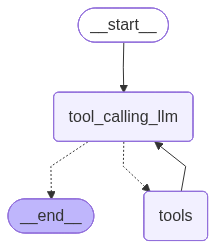

In [19]:
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [21]:
config = {"configurable": {"thread_id": "1"}}

response = graph_memory.invoke({"messages": "Hi my name is Akib Uddin Nayan"}, config)

In [22]:
response

{'messages': [HumanMessage(content='Hi my name is Akib Uddin Nayan', additional_kwargs={}, response_metadata={}, id='96b29045-2870-42f8-bd1e-47acf384ebf9'),
  AIMessage(content="Hello Akib Uddin Nayan, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 1892, 'total_tokens': 1924, 'completion_time': 0.074013321, 'prompt_time': 0.09542405, 'queue_time': 0.063110327, 'total_time': 0.169437371}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fe312f6b04', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3cb49819-8e37-4935-9bb3-c736ab754fe8-0', usage_metadata={'input_tokens': 1892, 'output_tokens': 32, 'total_tokens': 1924})]}

In [23]:
response = graph_memory.invoke({"messages": "What is my name?"}, config)
response

{'messages': [HumanMessage(content='Hi my name is Akib Uddin Nayan', additional_kwargs={}, response_metadata={}, id='96b29045-2870-42f8-bd1e-47acf384ebf9'),
  AIMessage(content="Hello Akib Uddin Nayan, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 1892, 'total_tokens': 1924, 'completion_time': 0.074013321, 'prompt_time': 0.09542405, 'queue_time': 0.063110327, 'total_time': 0.169437371}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fe312f6b04', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3cb49819-8e37-4935-9bb3-c736ab754fe8-0', usage_metadata={'input_tokens': 1892, 'output_tokens': 32, 'total_tokens': 1924}),
  HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='f1488ac3-8324-4555-9ea5-dd3a25185cb0'),
  AIMessage(content='Your name is Akib Uddin Naya

In [25]:
response = graph_memory.invoke({"messages": "I am a AI Engineer"}, config)
response

{'messages': [HumanMessage(content='Hi my name is Akib Uddin Nayan', additional_kwargs={}, response_metadata={}, id='96b29045-2870-42f8-bd1e-47acf384ebf9'),
  AIMessage(content="Hello Akib Uddin Nayan, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 1892, 'total_tokens': 1924, 'completion_time': 0.074013321, 'prompt_time': 0.09542405, 'queue_time': 0.063110327, 'total_time': 0.169437371}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fe312f6b04', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3cb49819-8e37-4935-9bb3-c736ab754fe8-0', usage_metadata={'input_tokens': 1892, 'output_tokens': 32, 'total_tokens': 1924}),
  HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='f1488ac3-8324-4555-9ea5-dd3a25185cb0'),
  AIMessage(content='Your name is Akib Uddin Naya

In [26]:
response = graph_memory.invoke({"messages": "What is my profession?"}, config)
response

{'messages': [HumanMessage(content='Hi my name is Akib Uddin Nayan', additional_kwargs={}, response_metadata={}, id='96b29045-2870-42f8-bd1e-47acf384ebf9'),
  AIMessage(content="Hello Akib Uddin Nayan, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 1892, 'total_tokens': 1924, 'completion_time': 0.074013321, 'prompt_time': 0.09542405, 'queue_time': 0.063110327, 'total_time': 0.169437371}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fe312f6b04', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3cb49819-8e37-4935-9bb3-c736ab754fe8-0', usage_metadata={'input_tokens': 1892, 'output_tokens': 32, 'total_tokens': 1924}),
  HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='f1488ac3-8324-4555-9ea5-dd3a25185cb0'),
  AIMessage(content='Your name is Akib Uddin Naya